# Lab 6: Deploy an image classification ML model in Azure Container Instance (ACI) with Azure ML
 
 <img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

Now, you're ready to deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/azure/container-instances/) (ACI). A web service is an image, in this case a Docker image, that encapsulates the scoring logic and the model itself. 

In this part of the tutorial, you use Azure Machine Learning service (Preview) to:

> * Set up your testing environment
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model

ACI is a great solution for testing and understanding the workflow. For scalable production deployments, consider using Azure Kubernetes Service. For more information, see [how to deploy and where](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).

## 1. Settings

In [1]:
import datetime
today = datetime.datetime.now()
print("Today is:", today)

Today is: 2021-02-08 09:41:51.011387


In [2]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

In [3]:
import sys
print("Python =", sys.version)

Python = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [4]:
import azureml.core
print("This Jupyter notebook was made using Azure ML 1.21.0")
print("You are using Azure ML", azureml.core.VERSION)

This Jupyter notebook was made using Azure ML 1.21.0
You are using Azure ML 1.21.0


## 2. Importing and referencing a model

We are going to register the pkl model into Azure ML.

In [5]:
# register a model
from azureml.core import Workspace
ws = Workspace.from_config()

from azureml.core.model import Model

model_name = "sklearn_mnist"
model = Model.register(model_path="sklearn_mnist_model.pkl",
                        model_name=model_name,
                        tags={"data": "Mnist", 
                              "model": "Classification", 
                              "source":"PKL file"},
                        description="Mnist handwriting recognition",
                        workspace=ws)

Registering model sklearn_mnist


In [6]:
print("Nom :", model.name)
print("ID :", model.id)
print("Version :", model.version)
print("Date :", model.created_time)

Nom : sklearn_mnist
ID : sklearn_mnist:34
Version : 34
Date : 2021-02-08 09:41:59.023733+00:00


In [7]:
from azureml.core.model import Model
model = Model(ws, 'sklearn_mnist')

## 3. Set up the environment

Start by setting up a testing environment.

### Import packages

Import the Python packages needed for this tutorial.

In [8]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# Environment to use
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 
                                            'azureml-defaults'],
                              conda_packages = ['scikit-learn==0.22.1'])
env.python.conda_dependencies = cd

In [9]:
# Register environment to re-use later
env.register(workspace = ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210104.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "tutorial-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import azureml.core

## 4. Deploy as web service

Deploy the model as a web service hosted in ACI. 

To build the correct environment for ACI, provide the following:
* A scoring script to show how to use the model
* A configuration file to build the ACI
* The model you trained before

### 4.1 Create scoring script

Create the scoring script, called score.py, used by the web service call to show how to use the model.

You must include two required functions into the scoring script:
* The `init()` function, which typically loads the model into a global object. This function is run only once when the Docker container is started. 

* The `run(input_data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.


In [11]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
import joblib

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting score.py


In [12]:
%ls score.py -l

-rwxrwxrwx 1 root root 704 Feb  8 09:42 score.py*


### 4.2 Create configuration file

Create a deployment configuration file and specify the number of CPUs and gigabyte of RAM needed for your ACI container. While it depends on your model, the default of 1 core and 1 gigabyte of RAM is usually sufficient for many models. If you feel you need more later, you would have to recreate the image and redeploy the service.

> https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.webservice.aci.aciwebservice?view=azure-ml-py

In [13]:
aci_tags={"Data": "MNIST", "Framework" : "sklearn", "Purpose" : "ACI Test"}

In [14]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               auth_enabled=False,
                                               ssl_enabled=False,
                                               enable_app_insights=True,
                                               tags=aci_tags, 
                                               description='Predict MNIST with sklearn using Azure ML')

### 4.3 Deploy in ACI

Configure the image and deploy. The following code goes through these steps:

1. Create environment object containing dependencies needed by the model using the environment file (`myenv.yml`)
1. Create inference configuration necessary to deploy the model as a web service using:
   * The scoring file (`score.py`)
   * envrionment object created in previous step
1. Deploy the model to the ACI container.
1. Get the web service HTTP endpoint.

In [15]:
%%time
import uuid
import datetime
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')

# Environment to use
myenv = Environment.get(workspace=ws, name="tutorial-env", version="1")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

# Name of the service (should be unique)
service_name = 'sklearn-mnist-svc-' + datetime.datetime.now().strftime("%m%d%H")

service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.............................
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 680 ms, sys: 86.6 ms, total: 767 ms
Wall time: 2min 44s


> It tooks usually around 2 or 3 minutes

Get the scoring web service's HTTP endpoint, which accepts REST client calls. **This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.**

In [16]:
print("Scoring URL:", service.scoring_uri)

Scoring URL: http://bfe41302-9667-4bcc-9203-3ec140c6f419.westeurope.azurecontainer.io/score


In [17]:
print("Status=", service.state)

Status= Healthy


In [18]:
service.properties

{'hasInferenceSchema': 'False', 'hasHttps': 'False'}

In [19]:
print(service.get_logs())

2021-02-08T09:44:57,704806780+00:00 - iot-server/run 
2021-02-08T09:44:57,705976084+00:00 - rsyslog/run 
2021-02-08T09:44:57,706980588+00:00 - gunicorn/run 
2021-02-08T09:44:57,718360027+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_414a168e50624dbd01498ea3ef01d1da/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_414a168e50624dbd01498ea3ef01d1da/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_414a168e50624dbd01498ea3ef01d1da/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_414a168e50624dbd01498ea3ef01d1da/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_414a168e50624dbd01498ea3ef01d1da/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
EdgeHubC

## 5. Test the model

### Download test data
Download the test data to the **./data/** directory

In [20]:
import os
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/instancenbooks/code/Users/seretkow/Workshop/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/instancenbooks/code/Users/seretkow/Workshop/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/instancenbooks/code/Users/seretkow/Workshop/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/instancenbooks/code/Users/seretkow/Workshop/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz']

### Load test data

Load the test data from the **./data/** directory created during the training tutorial.

In [21]:
from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')

X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

### Predict test data

Feed the test dataset to the model to get predictions.


The following code goes through these steps:
1. Send the data as a JSON array to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

In [22]:
import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

###  Examine the confusion matrix

Generate a confusion matrix to see how many samples from the test set are classified correctly. Notice the mis-classified value for the incorrect predictions.

In [23]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_hat)
print("Confusion Matrix:")
print()
print(conf_mat)

Confusion Matrix:

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]


### Overall model Accuracy

In [24]:
print('Accuracy =', np.average(y_hat == y_test))

Accuracy = 0.9193


## Show predictions

Test the deployed model with a random sample of 30 images from the test data.  

Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples. 

 Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

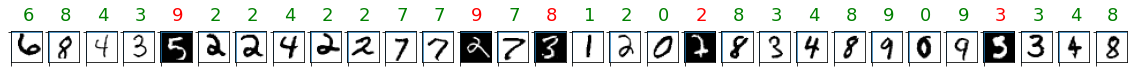

In [25]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'green'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

## You can also send raw HTTP requests to test the web service:

In [26]:
import requests

In [27]:
print("My scoring endpoint:", service.scoring_uri)

My scoring endpoint: http://bfe41302-9667-4bcc-9203-3ec140c6f419.westeurope.azurecontainer.io/score


### Test 1

In [28]:
%%time

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

#print("Input data:", input_data)
print("- Real value =", y_test[random_index])
print("- Azure ML model value Prediction =", resp.text)
print()

- Real value = 0
- Azure ML model value Prediction = [0]

CPU times: user 2.95 ms, sys: 783 µs, total: 3.73 ms
Wall time: 11.8 ms


### Test 2

In [29]:
%%time

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

#print("Input data:", input_data)
print("- Real value =", y_test[random_index])
print("- Azure ML model value Prediction =", resp.text)
print()

- Real value = 9
- Azure ML model value Prediction = [9]

CPU times: user 2.86 ms, sys: 757 µs, total: 3.61 ms
Wall time: 15.3 ms


### Test 3

In [32]:
%%time

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

#print("Input data:", input_data)
print("- Real value =", y_test[random_index])
print("- Azure ML model value Prediction =", resp.text)
print()

- Real value = 5
- Azure ML model value Prediction = [5]

CPU times: user 4.88 ms, sys: 214 µs, total: 5.1 ms
Wall time: 16.4 ms


## Clean up resources

You can delete only the ACI deployment using this API call:

In [33]:
service.delete()

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part2-deploy.png)